# Imports & Load Data

In [1]:
import numpy as np
import os
import glob
import shutil
import cv2
import matplotlib.pyplot as plt
import random
from typing import List, Tuple

In [2]:
%%capture
!pip install super-gradients==3.2.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

In [3]:
from google.colab import userdata

os.environ['WANDB_DISABLED'] = 'true'
roboflow_api = userdata.get('ROBOFLOW')

In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key=roboflow_api)
project = rf.workspace("brad-dwyer").project("pothole-voxrl")
version = project.version(1)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pothole-1 in yolov5pytorch:: 100%|██████████| 1342/1342 [00:00<00:00, 6112.33it/s]


In [5]:
DATA_PATH = '/content/Pothole-1'
YAML_PATH = os.path.join(DATA_PATH, 'data.yaml')
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TEST_PATH =  os.path.join(DATA_PATH, 'test')
VAL_PATH =   os.path.join(DATA_PATH, 'valid')

### Visualizing Data

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [7]:
def yolo2bbox(bboxes: List[float])->tuple[float]:
  """
  Convert bounding boxes from YOLO format to standard bounding box format.

  Args:
      bboxes (tuple or list of float): A tuple or list containing four elements representing the bounding box in YOLO format.
          - bboxes[0] (float): The x-coordinate of the center of the bounding box (normalized).
          - bboxes[1] (float): The y-coordinate of the center of the bounding box (normalized).
          - bboxes[2] (float): The width of the bounding box (normalized).
          - bboxes[3] (float): The height of the bounding box (normalized).

  Returns:
      tuple of float: A tuple representing the bounding box in standard format (xmin, ymin, xmax, ymax).
          - xmin (float): The x-coordinate of the bottom-left corner of the bounding box.
          - ymin (float): The y-coordinate of the bottom-left corner of the bounding box.
          - xmax (float): The x-coordinate of the top-right corner of the bounding box.
          - ymax (float): The y-coordinate of the top-right corner of the bounding box.
  """
  xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
  xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
  return xmin, ymin, xmax, ymax

def plot_bboxes(img: np.ndarray, bboxes: List[List[float]], labels: List[bool]=None)->np.ndarray:
  """
  Plot bounding boxes on an image with optional labels.

  Args:
      img (numpy.ndarray): The image on which to draw the bounding boxes.
          Should be a NumPy array with shape (H, W, C), where H is the height, W is the width, and C is the number of color channels (usually 3 for RGB).
      bboxes (list of tuples or lists of float): A list containing bounding boxes in YOLO format.
          Each bounding box is represented by a tuple or list with four elements:
          - x_center (float): The x-coordinate of the center of the bounding box (normalized).
          - y_center (float): The y-coordinate of the center of the bounding box (normalized).
          - width (float): The width of the bounding box (normalized).
          - height (float): The height of the bounding box (normalized).
      labels (list of int, optional): A list of labels corresponding to each bounding box. If provided, the label is used to determine the color of the bounding box.
          - 0 (int): Will be drawn in yellow.
          - 1 (int): Will be drawn in magenta.
          If None, default colors will be used.

  Returns:
      numpy.ndarray: The image with bounding boxes drawn on it. The image is returned in the same format as the input.
  """
  h, w, _ = img.shape
  if len(set(labels))<3:
    colors= [(i, j, k) for i in (0, 255) for j in (0, 255) for k in (0, 255) if not(i==j and j==k)]
  for box_num, box in enumerate(bboxes):
    x1, y1, x2, y2 = yolo2bbox(box)
    #Denormalizing the coordinates
    xmin = int(x1*w)
    ymin = int(y1*h)
    xmax = int(x2*w)
    ymax = int(y2*h)

    thickness = max(2, int(w/275))
    if len(set(labels))<3:
      color = colors[box_num%len(colors)]
    elif labels[box_num] == 0:
      color = (255, 255, 0)
    else:
      color = (200, 0, 255)
    cv2.rectangle(
        img,
        (xmin, ymin), (xmax, ymax),
        color = color,
        thickness = thickness
    )
  return img

In [8]:
def plot(images_path: str, labels_path: str, cols: int=4, rows: int= 3)->None:
  """
  Display a grid of images with their corresponding bounding boxes and labels.

  Args:
      images_path (str): Path to the directory containing images.
      labels_path (str): Path to the directory containing label files (one per image).
      cols (int, optional): Number of columns in the grid. Default is 4.
      rows (int, optional): Number of rows in the grid. Default is 3.

  Returns:
      None
  """
  all_images = os.listdir(images_path)
  all_images.sort()

  num_images = len(all_images)

  fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(20,20))
  for i in range(cols*rows):
    j = np.random.randint(0, num_images-1)
    image_path = os.path.join(images_path, all_images[j])
    label_path = os.path.join(labels_path, all_images[j][:-4]+'.txt')

    with open(label_path, 'r') as f:
      label_lines = f.readlines()
      annotations = [(list(map(float, annotation.split(' ')))) for annotation in label_lines]
      bboxes = []
      labels = []
      for annotation in annotations:
        labels.append(annotation[0])
        bboxes.append(annotation[1:])

    image = cv2.imread(image_path)
    res_image = plot_bboxes(image, bboxes, labels)
    ax.flatten()[i].imshow(image)

  plt.tight_layout()
  plt.show()

plot(os.path.join(TRAIN_PATH, 'images'), os.path.join(TRAIN_PATH, 'labels'), 3)

Output hidden; open in https://colab.research.google.com to view.

# Train YOLOvNAS with Ultralytics

### Loading model

In [9]:
from super_gradients.training import models

yolo_nas_l = models.get("yolo_nas_l", pretrained_weights="coco")

[2024-08-05 07:40:23] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-08-05 07:40:26] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-08-05 07:40:31] INFO - utils.py - NumExpr defaulting to 2 threads.
Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
[2024-08-05 07:40:33] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-08-05 07:40:33] WARNING - export.py - Failed to import pytorch_quantization
[2024-08-05 07:40:33] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2024-08-05 07:40:33] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2024-08-05 07:40:33] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2024-08-05 07:40:33] WARNING - env_sanity_check.py - Failed to verify installed 

In [10]:
!pip install torchinfo
from torchinfo import summary

summary(model=yolo_nas_l,
        input_size=(16, 3, 640, 640),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
YoloNAS_L (YoloNAS_L)                                             [16, 3, 640, 640]    [16, 8400, 4]        --                   True
├─NStageBackbone (backbone)                                       [16, 3, 640, 640]    [16, 96, 160, 160]   --                   True
│    └─YoloNASStem (stem)                                         [16, 3, 640, 640]    [16, 48, 320, 320]   --                   True
│    │    └─QARepVGGBlock (conv)                                  [16, 3, 640, 640]    [16, 48, 320, 320]   3,024                True
│    └─YoloNASStage (stage1)                                      [16, 48, 320, 320]   [16, 96, 160, 160]   --                   True
│    │    └─QARepVGGBlock (downsample)                            [16, 48, 320, 320]   [16, 96, 160, 160]   88,128               True
│    │    └─YoloNASCSPLayer (blocks)                     

### Preparing Dataset

In [11]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [12]:
dataset_params = {
    'data_dir': DATA_PATH,
    'train_images_dir': os.path.join(TRAIN_PATH, "images"),
    'train_labels_dir': os.path.join(TRAIN_PATH, "labels"),
    'val_images_dir': os.path.join(VAL_PATH, "images"),
    'val_labels_dir': os.path.join(VAL_PATH, "labels"),
    'test_images_dir': os.path.join(TEST_PATH, "images"),
    'test_labels_dir': os.path.join(TEST_PATH, "labels"),
    'classes': ["pothole", ],
}

In [13]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

[2024-08-05 07:40:52] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 465/465 [00:00<00:00, 1243.06it/s]
[2024-08-05 07:40:53] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 133/133 [00:00<00:00, 1344.68it/s]
[2024-08-05 07:40:54] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


In [14]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

Indexing dataset annotations: 100%|██████████| 67/67 [00:00<00:00, 992.42it/s]


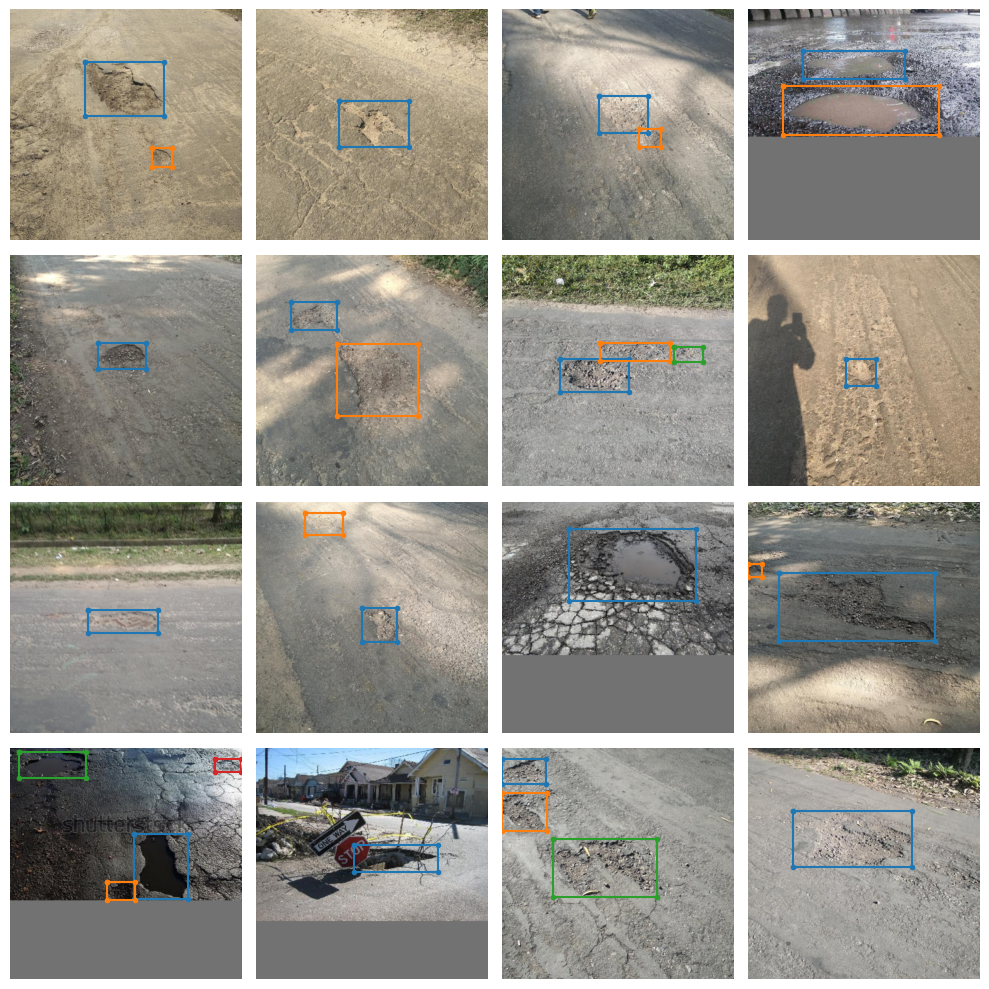

In [15]:
val_data.dataset.plot()

### SuperGradients Trainer

In [16]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
RUN_NAME = 'yolonas_run'
trainer = Trainer(experiment_name=RUN_NAME, ckpt_root_dir=CHECKPOINT_DIR)

In [17]:
from super_gradients.training import models
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2024-08-05 07:41:07] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-08-05 07:41:08] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


In [18]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [19]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

The console stream is now moved to checkpoints/yolonas_run/console_Aug05_07_41_14.txt


[2024-08-05 07:41:20] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[2024-08-05 07:41:26] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 465        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         29         (len(train_loader))
    - Gradient updates per epoch:   29         (len(train_loader) / batch_accumulate)

[2024-08-05 07:41:26] INFO - sg_trainer.py - Started

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.0584
│   ├── Ppyoloeloss/loss_iou = 0.3546
│   ├── Ppyoloeloss/loss_dfl = 1.7332
│   └── Ppyoloeloss/loss = 3.8114
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.2234
    ├── Ppyoloeloss/loss_iou = 0.2859
    ├── Ppyoloeloss/loss_dfl = 1.6303
    ├── Ppyoloeloss/loss = 3.7531
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0084
    └── F1@0.50 = 0.0



Validating epoch 1: 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]
[2024-08-05 07:43:20] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolonas_run/ckpt_best.pth
[2024-08-05 07:43:20] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.2524851858615875


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3548
│   │   ├── Epoch N-1      = 2.0584 (↘ -0.7036)
│   │   └── Best until now = 2.0584 (↘ -0.7036)
│   ├── Ppyoloeloss/loss_iou = 0.2865
│   │   ├── Epoch N-1      = 0.3546 (↘ -0.0681)
│   │   └── Best until now = 0.3546 (↘ -0.0681)
│   ├── Ppyoloeloss/loss_dfl = 1.4664
│   │   ├── Epoch N-1      = 1.7332 (↘ -0.2668)
│   │   └── Best until now = 1.7332 (↘ -0.2668)
│   └── Ppyoloeloss/loss = 2.8042
│       ├── Epoch N-1      = 3.8114 (↘ -1.0072)
│       └── Best until now = 3.8114 (↘ -1.0072)
└── Validation
    ├── Ppyoloeloss/loss_cls = 22.3729
    │   ├── Epoch N-1      = 2.2234 (↗ 20.1495)
    │   └── Best until now = 2.2234 (↗ 20.1495)
    ├── Ppyoloeloss/loss_iou = 0.2425
    │   ├── Epoch N-1      = 0.2859 (↘ -0.0433)
    │   └── Best until now = 0.2859 (↘ -0.0433)
    ├── Ppyoloeloss/loss_dfl = 1.3964
    │   ├── Epoch N-1      = 1.6303 (↘ -0.2338)
    │   └── Best until now = 1.6303 (↘ -0.2338)
    ├── Ppyoloeloss/l

Validating epoch 2: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]
[2024-08-05 07:45:44] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolonas_run/ckpt_best.pth
[2024-08-05 07:45:44] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.3609410524368286


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1559
│   │   ├── Epoch N-1      = 1.3548 (↘ -0.1989)
│   │   └── Best until now = 1.3548 (↘ -0.1989)
│   ├── Ppyoloeloss/loss_iou = 0.2669
│   │   ├── Epoch N-1      = 0.2865 (↘ -0.0196)
│   │   └── Best until now = 0.2865 (↘ -0.0196)
│   ├── Ppyoloeloss/loss_dfl = 1.3673
│   │   ├── Epoch N-1      = 1.4664 (↘ -0.099)
│   │   └── Best until now = 1.4664 (↘ -0.099)
│   └── Ppyoloeloss/loss = 2.5069
│       ├── Epoch N-1      = 2.8042 (↘ -0.2973)
│       └── Best until now = 2.8042 (↘ -0.2973)
└── Validation
    ├── Ppyoloeloss/loss_cls = 3.6048
    │   ├── Epoch N-1      = 22.3729 (↘ -18.7681)
    │   └── Best until now = 2.2234 (↗ 1.3814)
    ├── Ppyoloeloss/loss_iou = 0.2248
    │   ├── Epoch N-1      = 0.2425 (↘ -0.0177)
    │   └── Best until now = 0.2425 (↘ -0.0177)
    ├── Ppyoloeloss/loss_dfl = 1.2754
    │   ├── Epoch N-1      = 1.3964 (↘ -0.121)
    │   └── Best until now = 1.3964 (↘ -0.121)
    ├── Ppyoloeloss/loss 

Validating epoch 3: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1394
│   │   ├── Epoch N-1      = 1.1559 (↘ -0.0165)
│   │   └── Best until now = 1.1559 (↘ -0.0165)
│   ├── Ppyoloeloss/loss_iou = 0.2593
│   │   ├── Epoch N-1      = 0.2669 (↘ -0.0076)
│   │   └── Best until now = 0.2669 (↘ -0.0076)
│   ├── Ppyoloeloss/loss_dfl = 1.363
│   │   ├── Epoch N-1      = 1.3673 (↘ -0.0044)
│   │   └── Best until now = 1.3673 (↘ -0.0044)
│   └── Ppyoloeloss/loss = 2.4693
│       ├── Epoch N-1      = 2.5069 (↘ -0.0376)
│       └── Best until now = 2.5069 (↘ -0.0376)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.6512
    │   ├── Epoch N-1      = 3.6048 (↘ -0.9537)
    │   └── Best until now = 2.2234 (↗ 0.4278)
    ├── Ppyoloeloss/loss_iou = 0.2478
    │   ├── Epoch N-1      = 0.2248 (↗ 0.023)
    │   └── Best until now = 0.2248 (↗ 0.023)
    ├── Ppyoloeloss/loss_dfl = 1.4183
    │   ├── Epoch N-1      = 1.2754 (↗ 0.1429)
    │   └── Best until now = 1.2754 (↗ 0.1429)
    ├── Ppyoloeloss/loss = 3.9

Validating epoch 4: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1232
│   │   ├── Epoch N-1      = 1.1394 (↘ -0.0162)
│   │   └── Best until now = 1.1394 (↘ -0.0162)
│   ├── Ppyoloeloss/loss_iou = 0.2551
│   │   ├── Epoch N-1      = 0.2593 (↘ -0.0042)
│   │   └── Best until now = 0.2593 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_dfl = 1.3354
│   │   ├── Epoch N-1      = 1.363  (↘ -0.0276)
│   │   └── Best until now = 1.363  (↘ -0.0276)
│   └── Ppyoloeloss/loss = 2.4287
│       ├── Epoch N-1      = 2.4693 (↘ -0.0405)
│       └── Best until now = 2.4693 (↘ -0.0405)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.7112
    │   ├── Epoch N-1      = 2.6512 (↘ -0.9399)
    │   └── Best until now = 2.2234 (↘ -0.5122)
    ├── Ppyoloeloss/loss_iou = 0.2295
    │   ├── Epoch N-1      = 0.2478 (↘ -0.0183)
    │   └── Best until now = 0.2248 (↗ 0.0047)
    ├── Ppyoloeloss/loss_dfl = 1.3445
    │   ├── Epoch N-1      = 1.4183 (↘ -0.0739)
    │   └── Best until now = 1.2754 (↗ 0.0691)
    ├── Ppyoloeloss/loss

Validating epoch 5: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1043
│   │   ├── Epoch N-1      = 1.1232 (↘ -0.0189)
│   │   └── Best until now = 1.1232 (↘ -0.0189)
│   ├── Ppyoloeloss/loss_iou = 0.2446
│   │   ├── Epoch N-1      = 0.2551 (↘ -0.0105)
│   │   └── Best until now = 0.2551 (↘ -0.0105)
│   ├── Ppyoloeloss/loss_dfl = 1.2915
│   │   ├── Epoch N-1      = 1.3354 (↘ -0.0439)
│   │   └── Best until now = 1.3354 (↘ -0.0439)
│   └── Ppyoloeloss/loss = 2.3615
│       ├── Epoch N-1      = 2.4287 (↘ -0.0672)
│       └── Best until now = 2.4287 (↘ -0.0672)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5273
    │   ├── Epoch N-1      = 1.7112 (↘ -0.1839)
    │   └── Best until now = 1.7112 (↘ -0.1839)
    ├── Ppyoloeloss/loss_iou = 0.2326
    │   ├── Epoch N-1      = 0.2295 (↗ 0.0031)
    │   └── Best until now = 0.2248 (↗ 0.0078)
    ├── Ppyoloeloss/loss_dfl = 1.3366
    │   ├── Epoch N-1      = 1.3445 (↘ -0.0078)
    │   └── Best until now = 1.2754 (↗ 0.0613)
    ├── Ppyoloeloss/loss 

Validating epoch 6: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]
[2024-08-05 07:53:06] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolonas_run/ckpt_best.pth
[2024-08-05 07:53:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5742794871330261


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0692
│   │   ├── Epoch N-1      = 1.1043 (↘ -0.0351)
│   │   └── Best until now = 1.1043 (↘ -0.0351)
│   ├── Ppyoloeloss/loss_iou = 0.2359
│   │   ├── Epoch N-1      = 0.2446 (↘ -0.0087)
│   │   └── Best until now = 0.2446 (↘ -0.0087)
│   ├── Ppyoloeloss/loss_dfl = 1.2648
│   │   ├── Epoch N-1      = 1.2915 (↘ -0.0267)
│   │   └── Best until now = 1.2915 (↘ -0.0267)
│   └── Ppyoloeloss/loss = 2.2913
│       ├── Epoch N-1      = 2.3615 (↘ -0.0701)
│       └── Best until now = 2.3615 (↘ -0.0701)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4039
    │   ├── Epoch N-1      = 1.5273 (↘ -0.1235)
    │   └── Best until now = 1.5273 (↘ -0.1235)
    ├── Ppyoloeloss/loss_iou = 0.204
    │   ├── Epoch N-1      = 0.2326 (↘ -0.0286)
    │   └── Best until now = 0.2248 (↘ -0.0208)
    ├── Ppyoloeloss/loss_dfl = 1.1685
    │   ├── Epoch N-1      = 1.3366 (↘ -0.1682)
    │   └── Best until now = 1.2754 (↘ -0.1069)
    ├── Ppyoloeloss/los

Validating epoch 7: 100%|██████████| 9/9 [00:07<00:00,  1.28it/s]
[2024-08-05 07:56:00] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolonas_run/ckpt_best.pth
[2024-08-05 07:56:00] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5973721742630005


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0589
│   │   ├── Epoch N-1      = 1.0692 (↘ -0.0102)
│   │   └── Best until now = 1.0692 (↘ -0.0102)
│   ├── Ppyoloeloss/loss_iou = 0.2249
│   │   ├── Epoch N-1      = 0.2359 (↘ -0.011)
│   │   └── Best until now = 0.2359 (↘ -0.011)
│   ├── Ppyoloeloss/loss_dfl = 1.226
│   │   ├── Epoch N-1      = 1.2648 (↘ -0.0389)
│   │   └── Best until now = 1.2648 (↘ -0.0389)
│   └── Ppyoloeloss/loss = 2.2341
│       ├── Epoch N-1      = 2.2913 (↘ -0.0573)
│       └── Best until now = 2.2913 (↘ -0.0573)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1617
    │   ├── Epoch N-1      = 1.4039 (↘ -0.2422)
    │   └── Best until now = 1.4039 (↘ -0.2422)
    ├── Ppyoloeloss/loss_iou = 0.2
    │   ├── Epoch N-1      = 0.204  (↘ -0.004)
    │   └── Best until now = 0.204  (↘ -0.004)
    ├── Ppyoloeloss/loss_dfl = 1.1415
    │   ├── Epoch N-1      = 1.1685 (↘ -0.027)
    │   └── Best until now = 1.1685 (↘ -0.027)
    ├── Ppyoloeloss/loss = 2.232

Validating epoch 8: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]
[2024-08-05 07:59:18] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolonas_run/ckpt_best.pth
[2024-08-05 07:59:19] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6219363808631897


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0265
│   │   ├── Epoch N-1      = 1.0589 (↘ -0.0325)
│   │   └── Best until now = 1.0589 (↘ -0.0325)
│   ├── Ppyoloeloss/loss_iou = 0.2216
│   │   ├── Epoch N-1      = 0.2249 (↘ -0.0033)
│   │   └── Best until now = 0.2249 (↘ -0.0033)
│   ├── Ppyoloeloss/loss_dfl = 1.1854
│   │   ├── Epoch N-1      = 1.226  (↘ -0.0406)
│   │   └── Best until now = 1.226  (↘ -0.0406)
│   └── Ppyoloeloss/loss = 2.1731
│       ├── Epoch N-1      = 2.2341 (↘ -0.0609)
│       └── Best until now = 2.2341 (↘ -0.0609)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0965
    │   ├── Epoch N-1      = 1.1617 (↘ -0.0651)
    │   └── Best until now = 1.1617 (↘ -0.0651)
    ├── Ppyoloeloss/loss_iou = 0.203
    │   ├── Epoch N-1      = 0.2    (↗ 0.003)
    │   └── Best until now = 0.2    (↗ 0.003)
    ├── Ppyoloeloss/loss_dfl = 1.1627
    │   ├── Epoch N-1      = 1.1415 (↗ 0.0212)
    │   └── Best until now = 1.1415 (↗ 0.0212)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 9: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]
[2024-08-05 08:02:12] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolonas_run/ckpt_best.pth
[2024-08-05 08:02:12] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6360017657279968


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0357
│   │   ├── Epoch N-1      = 1.0265 (↗ 0.0093)
│   │   └── Best until now = 1.0265 (↗ 0.0093)
│   ├── Ppyoloeloss/loss_iou = 0.2201
│   │   ├── Epoch N-1      = 0.2216 (↘ -0.0015)
│   │   └── Best until now = 0.2216 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 1.1847
│   │   ├── Epoch N-1      = 1.1854 (↘ -0.0006)
│   │   └── Best until now = 1.1854 (↘ -0.0006)
│   └── Ppyoloeloss/loss = 2.1784
│       ├── Epoch N-1      = 2.1731 (↗ 0.0052)
│       └── Best until now = 2.1731 (↗ 0.0052)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.076
    │   ├── Epoch N-1      = 1.0965 (↘ -0.0205)
    │   └── Best until now = 1.0965 (↘ -0.0205)
    ├── Ppyoloeloss/loss_iou = 0.1954
    │   ├── Epoch N-1      = 0.203  (↘ -0.0076)
    │   └── Best until now = 0.2    (↘ -0.0046)
    ├── Ppyoloeloss/loss_dfl = 1.1379
    │   ├── Epoch N-1      = 1.1627 (↘ -0.0248)
    │   └── Best until now = 1.1415 (↘ -0.0036)
    ├── Ppyoloeloss/loss = 

[2024-08-05 08:04:24] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 10: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


In [21]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path=os.path.join(CHECKPOINT_DIR, RUN_NAME, 'average_model.pth'))

[2024-08-05 08:10:02] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints/yolonas_run/average_model.pth EMA checkpoint.


# Inference and Benchmarking

### Benchmarking on Validation and Test set

In [22]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(
                                                       score_threshold=0.01,
                                                      nms_top_k=1000,
                                                      max_predictions=300,
                                                      nms_threshold=0.7)
                                                  ))

Testing: 100%|██████████| 5/5 [00:03<00:00,  1.72it/s]

{'PPYoloELoss/loss_cls': 1.0845907,
 'PPYoloELoss/loss_iou': 0.18958063,
 'PPYoloELoss/loss_dfl': 1.1419393,
 'PPYoloELoss/loss': 2.1295118,
 'Precision@0.50': 0.0221452247351408,
 'Recall@0.50': 0.9607843160629272,
 'mAP@0.50': 0.6407290101051331,
 'F1@0.50': 0.04329259693622589}

Testing: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


In [28]:
trainer.test(model=best_model,
            test_loader=val_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.3,
                                                   top_k_predictions=30,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(
                                                       score_threshold=0.01,
                                                      nms_top_k=100,
                                                      max_predictions=30,
                                                      nms_threshold=0.7)
                                                  ))

Testing: 100%|██████████| 9/9 [00:08<00:00,  1.23it/s]

{'PPYoloELoss/loss_cls': 1.0760022,
 'PPYoloELoss/loss_iou': 0.19539307,
 'PPYoloELoss/loss_dfl': 1.1378973,
 'PPYoloELoss/loss': 2.1334333,
 'Precision@0.50': 0.3746130168437958,
 'Recall@0.50': 0.7333333492279053,
 'mAP@0.50': 0.6215043067932129,
 'F1@0.50': 0.4959016740322113}

[2024-08-05 08:10:26] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


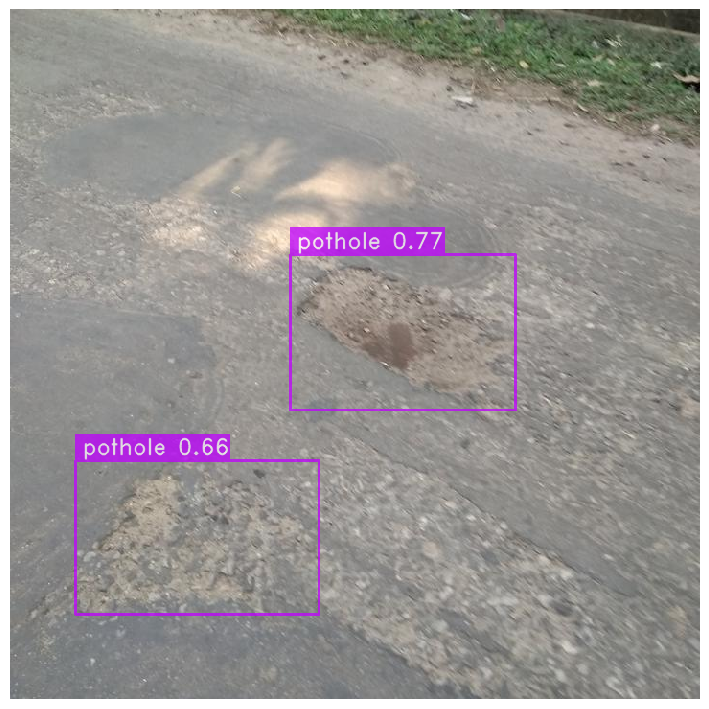

In [23]:
img_path = "/content/Pothole-1/valid/images/img-116_jpg.rf.09abd4f4dd5161e4a14cdd87d23b2cab.jpg"
best_model.predict(img_path).show()

### Inference Pipeline

In [56]:
outputs = best_model.predict(img_path)

[2024-08-05 09:09:58] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


In [52]:
def visualization_inference_pipeline(model, path: str=None, img: np.ndarray=None)->np.ndarray:
    if path is None and img is None:
      assert ValueError("Either img_path or img must be provided")
      return None
    if img is None:
      img = cv2.imread(path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    outputs = model.predict(img)
    boxes = outputs._images_prediction_lst[0].prediction.bboxes_xyxy
    labels = outputs._images_prediction_lst[0].prediction.labels
    res = plot_bboxes(img, boxes, labels)
    return img